Akhil Agnihotri | 9549446174 | hw2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
import time

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# jtplot.style(theme='monokai', grid=False)
# jtplot.reset()
plt.style.use('ggplot')

In [2]:
class PowerPlant():
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.data = pd.DataFrame()
        self.X_data = pd.DataFrame()
        self.Y_data = pd.DataFrame()
        self.univariate_coeff = {}
        self.multivariate_coeff = {}
        self.lowest_mse = {}
        self.big_space = '\n\n ~~~ \n\n'
        
    def load_data(self):
        data = pd.read_excel(self.data_path)
        self.data = data
        self.X_data = data.iloc[:,:-1]
        self.Y_data = data.iloc[:,-1]
        self.variables = self.data.columns.values[:-1]
        
    def data_stats(self):
        
        print('Shape of data is {}.'.format(self.data.shape), 'Rows are data points, columns are variables')
        sns.pairplot(self.data, diag_kind = 'hist')
        plt.show()
        print('The variables seem to be correlated')
        
        data_stats = self.data.describe()
        data_stats.loc['range'] = data_stats.loc['max'] - data_stats.loc['min']
        data_stats.loc['IQR'] = data_stats.loc['75%'] - data_stats.loc['25%']
        print(' \n \t \t Data Statistics \n')
        print(data_stats)
        
    def individual_regression(self, polynomial = False):
        
        regression_stats = []
        
        fig = plt.figure(figsize=(10,10))
        n_row = n_col = 2
        plot_num = 1
        
        for variable in self.variables:
            if(polynomial == True):
                x = np.array(self.X_data[variable]).reshape(-1,1)
                polynomial_features = PolynomialFeatures(degree=3)
                x_constant = polynomial_features.fit_transform(x)
            else:
                x = self.X_data[variable]
                x_constant = sm.add_constant(x)
            
            y = self.Y_data
            model = sm.OLS(y, x_constant)
            reg = model.fit()
            
            
            r_sq_adj = reg.rsquared_adj
            p_value = reg.f_pvalue
            regression_stats.append([variable,r_sq_adj,p_value])
            
            weights = np.reshape(np.asarray(reg.params),(-1,1))
            y_predict = np.matmul(np.array(x_constant),weights)
            
            if(polynomial == True): 
                print(self.big_space)
                print(variable)
                print(reg.summary().tables[1])
                print(self.big_space)
            else:
                self.univariate_coeff[variable] = reg.params[1]            

            plt.subplot(n_row, n_col, plot_num)
            plt.scatter(x, y, s=.5, label='Actual')
            plt.scatter(x, y_predict, s=0.5, label='Predicted')
            plt.legend(markerscale=7.5,labelcolor='black',facecolor='yellowgreen')
            plt.title(variable, color='black')
        
            plot_num += 1
        
        plt.show()
        
        regression_stats_df = pd.DataFrame(regression_stats, columns = ['variable','r_sq_adj','p_value'])
        print(regression_stats_df)
        
        print(self.big_space)
        if(polynomial == True):
            print("""p_values are ~0 for all variables in their non-linear univariate regression \n
                     Hence, non-linear interaction is present \n
                     Higher adjusted R-square values are also observed for ALL variables \n
                     Hence, non-linear univariable regression is better than linear
                    """)
        else:
            print("""The strongest association is for the variable AT, and least for RH \n
                     There seem to be some outliers in variables V and RH \n
                     Best fit seems to be for AT as confirmed by the high adjusted R-square value
                     """)
        print(self.big_space)
        
    def multiple_regression(self):
        
        regression_stats = []
        
        x = self.X_data
        x_constant = sm.add_constant(x)
        y = self.Y_data
        model = sm.OLS(y, x_constant)
        reg = model.fit()
        
        self.multivariate_coeff = reg.params.to_dict()
    
        print(reg.summary())
        print(self.big_space)
        print('Adjusted R-square is high which is good')
        print('F_stat probability ~ 0 which means at least one variable is important for prediction')
        print('Since p_value of all variables ~0, we can reject null hypothesis for all of them')
        print(self.big_space)
          
    def compare_regression(self):
        
        plt.figure(figsize=(8,8))
        
        for variable in self.variables:
            plt.scatter(self.univariate_coeff[variable],self.multivariate_coeff[variable], 
                        s=200, label=variable)
        
        
        plt.title('Univariate and Multivariate coefficient comparison')
        plt.legend(labelcolor='black',facecolor='yellowgreen')
        plt.show()
        
        print(self.big_space)
        print('Only for variable AT the values for both regressions are similar')
        print('Other variables\' coefficients change in both cases')
        print(self.big_space)
        
    def interaction_helper(self, v1, v2):
        
        x1 = np.array(self.X_data[v1]).reshape(-1,1)
        x2 = np.array(self.X_data[v2]).reshape(-1,1)
        x_interaction = np.multiply(x1, x2)
        x_data = np.hstack((x1,x2,x_interaction))
        x_constant = sm.add_constant(x_data)
        
        return x_constant
    
    def interaction_regression(self):
        
        regression_stats = []
        
        fig = plt.figure(figsize=(14,14))
        n_row = 2
        n_col = 3
        plot_num = 1
        num_vars = len(self.variables)
        
        for i in range(num_vars):
            for j in range(i+1,num_vars):
                v1 = self.variables[i]
                v2 = self.variables[j]
                variable = '{} * {}'.format(v1,v2)
                x_constant = self.interaction_helper(v1,v2)
                y = self.Y_data
                model = sm.OLS(y, x_constant)
                reg = model.fit()
                
                print(self.big_space)
                print('\t\t',variable)
                print(reg.summary().tables[1])
                print(self.big_space)
                
                r_sq_adj = reg.rsquared_adj
                reg_html = reg.summary().tables[1].as_html()
                reg_df = pd.read_html(reg_html, header=0, index_col=0)[0]
                p_value = reg_df.iloc[-1]['P>|t|']
                regression_stats.append([variable,r_sq_adj,p_value])

                weights = np.reshape(np.asarray(reg.params),(-1,1))
                y_predict = np.matmul(np.array(x_constant),weights)
                
                
                plt.subplot(n_row, n_col, plot_num)
                plt.scatter(y, y_predict, s=0.5)
                plt.plot(y, y, 'b-', linewidth=2)
                plt.text(0.5, 0.85, 'y=x line', color='black',
                         fontsize=15, bbox=dict(facecolor='yellowgreen', alpha=0.5), 
                         transform=plt.gca().transAxes)
                plt.xlabel('Actual y')
                plt.ylabel('Predicted y')
                plt.title(variable, color='black')

                plot_num += 1
                
        plt.show()
        
        regression_stats_df = pd.DataFrame(regression_stats, 
                                           columns = ['interaction_term','r_sq_adj','total_p_value'])
        print(self.big_space)
        print(regression_stats_df)
        print(self.big_space)
        print("""x3 is the interaction variable in regression. 
                 For (AP,RH) the p-value is 0.002 and (AT,AP) the p-value is 0.525. Rest have p-value 0.
                 Hence, except for (AT,AP) there is statistical evidence (for alpha=0.05) for interaction.
                 However, R-square for (AP,RH) is 0.38 which means it is not a good fit model.
              """)
        print(self.big_space)
        
    def best_regression_helper(self, data, transform=False):
        
        X = data.iloc[:,:-1]
        Y = data.iloc[:, -1]
        
        if(transform == True):
            for variable in self.variables:
                quad_var = '{}**2'.format(variable)
                X[quad_var] = X[variable]**2

            num_vars = len(self.variables)
            for i in range(num_vars):
                for j in range(i+1,num_vars):
                    v1 = self.variables[i]
                    v2 = self.variables[j]
                    x1 = np.array(X[v1]).reshape(-1,1)
                    x2 = np.array(X[v2]).reshape(-1,1)
                    x_interaction = np.multiply(x1, x2)
                    inter_var = '{}*{}'.format(v1,v2)
                    X[inter_var] = x_interaction
        
        X_constant = sm.add_constant(X)
        
        return X_constant, Y
        
    def best_regression(self, test_fraction = 0.2):
        
        data_train, data_test = train_test_split(self.data, test_size=test_fraction)
        
        model_dict = {'Simple':False,'Everything':True}
        regression_stats = []
        
        plt.figure(figsize=(10,7))
        n_col = 2
        n_row = 1
        plot_num = 1
        
        for key in model_dict.keys():
            parity = model_dict[key]
            X_train, Y_train = self.best_regression_helper(data_train, transform=parity)
            X_test , Y_test  = self.best_regression_helper(data_test , transform=parity)
            
            model = sm.OLS(Y_train, X_train)
            reg = model.fit()

            r_sq_adj = reg.rsquared_adj
            p_value = reg.f_pvalue

            weights = np.reshape(np.asarray(reg.params),(-1,1))
            y_train_predict = np.matmul(np.array(X_train),weights)
            y_test_predict  = np.matmul(np.array(X_test) ,weights)
            
            mse_train = mean_squared_error(Y_train,y_train_predict)
            mse_test  = mean_squared_error(Y_test,y_test_predict)
            
            regression_name = key + ' Regression'
            self.lowest_mse[regression_name] = mse_test
            
            regression_stats.append([key,r_sq_adj,p_value,mse_train,mse_test])

            plt.subplot(n_row, n_col, plot_num)
            plt.scatter(Y_test, y_test_predict, s=0.5)
            plt.plot(Y_test, Y_test, 'b-', linewidth=2)
            plt.text(0.5, 0.85, 'y=x line', color='black',
                     fontsize=15, bbox=dict(facecolor='yellowgreen', alpha=0.5), 
                     transform=plt.gca().transAxes)
            plt.xlabel('Actual y')
            plt.ylabel('Predicted y')
            plt.title('Model = {}'.format(key), color='black')
            
            plot_num += 1
            
        
        plt.show()
        
        print(self.big_space)
        columns = ['Model','r_sq_adj','overall_p_value','mse_train','mse_test']
        regression_stats_df = pd.DataFrame(regression_stats, columns = columns)
        print(regression_stats_df)
        print(self.big_space)
        print('Lower train and test errors for the complicated model. Hence, better')
        print(self.big_space)
        
    def knn_regression_helper(self, normalized = False, test_fraction = 0.25, k_range = range(1,2)):
        
        data = self.data
        
        if(normalized == True):
            cols_to_norm = data.columns.values[:-1]
            data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
            
        data_train, data_test = train_test_split(data, test_size=test_fraction)
        X_train = data_train.iloc[:,:-1]
        Y_train = data_train.iloc[:,-1]
        X_test  = data_test.iloc[:,:-1]
        Y_test  = data_test.iloc[:,-1]
        
        mse_dict = {'Training':[],'Testing':[]}
        
        for k in k_range:
            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_train, Y_train)
            
            train_predict = model.predict(X_train)
            test_predict  = model.predict(X_test)
            
            mse_train = mean_squared_error(train_predict, Y_train)
            mse_test  = mean_squared_error(test_predict, Y_test)
            mse_dict['Training'].append(mse_train)
            mse_dict['Testing'].append(mse_test)
            
        for key in mse_dict.keys():
            plt.plot(k_range, mse_dict[key], label=key)
        
        plt.xlabel('k')
        plt.ylabel('MSE')
        plt.legend(markerscale=2,labelcolor='black',facecolor='yellowgreen')
        plt.title('Normalization = {}'.format(normalized), color='black')
        plt.show()
        
        lowest_error_idx = np.argmin(mse_dict['Testing'])   # best k from testing mse
        lowest_mse = mse_dict['Testing'][lowest_error_idx]
        best_k = k_range[lowest_error_idx]
        
        return best_k, lowest_mse
        
    def knn_regression(self, test_fraction = 0.25):
        
        model_dict = {'Raw':False,'Normalized':True}
        k_range = range(1,101)
    
        model_summary = []
        
        for key in model_dict.keys():
            k_best, lowest_mse = self.knn_regression_helper(normalized = model_dict[key], 
                                                            test_fraction = test_fraction, 
                                                            k_range = range(1,101))
            summary = [key,k_best,lowest_mse]
            model_summary.append(summary)
            
            regression_name = key + ' KNN'
            self.lowest_mse[regression_name] = lowest_mse
            
        model_summary_df = pd.DataFrame(model_summary, columns = ['data_transform','best_k','lowerst_test_mse'])
        
        print(self.big_space)
        print(model_summary_df)
        print(self.big_space)
            
    def regression_vs_knn(self):
        
        comparison_df = pd.DataFrame.from_dict(self.lowest_mse, orient='index', columns=['lowest_test_mse'])
        
        print(self.big_space)
        print(comparison_df)
        print(self.big_space)
        
        print("""As evident Normalized KNN gives the lowest MSE while Simple Regression gives the highest.
                This is intuitive since simple regression is not normalized, and does not consider interaction.
                Normalized KNN by virtue of its structure gives the best possible model.
              """)
        
    def question_two(self):
        
        print(""" 
        
            (a) Better - flexible model will capture different relationships between variables 
            when sample size is large.

            (b) Worse - flexible model might overfit when sample size is small.

            (c) Better - flexible model will be able to capture high degrees of freedom and complicated
            relationships between input variables.

            (d) Worse - flexible model will try to fit the data even though the noise / variance is high   
        """)
        
    def question_three(self, near = [0]):
        
        samples = [[0,3,0,'Red'],
                  [2,0,0,'Red'],
                  [0,1,3,'Red'],
                  [0,1,2,'Green'],
                  [-1,0,1,'Green'],
                  [1,1,1,'Red']]
        
        A = pd.DataFrame(samples,columns=['x1','x2','x3','y'])
               
        A['dist_from_origin'] = np.linalg.norm(A[['x1','x2','x3']].values,axis=1)
        
        print(A)
        print(self.big_space)
        
        predictions = {}
        close_points = {}
        print('(b) and (c) \n')
        for n in near:
            print('\n {} closest points'.format(n))
            smallest = A.nsmallest(n,'dist_from_origin')
            print(smallest)
            nearest = list(smallest['y'])
            predictions[n] = max(nearest,key=nearest.count)
        
        print(self.big_space)
        print('KNN Predictions :',predictions,'\n')
        print('(d) \t', 'Small. A smaller K would be flexible for a non-linear decision boundary')
        print(self.big_space)
        
    def run_questions(self, question = ''):
        self.load_data()
        if(question == '1.b.i'):
            self.data_stats()
        elif(question == '1.c'):
            self.individual_regression()
        elif(question == '1.d'):
            self.multiple_regression()
        elif(question == '1.e'):
            self.compare_regression()
        elif(question == '1.f'):
            self.individual_regression(polynomial=True)
        elif(question == '1.g'):
            self.interaction_regression()
        elif(question == '1.h'):
            self.best_regression(test_fraction = 0.3)
        elif(question == '1.i'):
            self.knn_regression(test_fraction = 0.25)
        elif(question == '1.j'):
            self.regression_vs_knn()
        elif(question == '2'):
            self.question_two()
        elif(question == '3'):
            self.question_three(near = [1,3])
        else:
            print('Please enter correct question number')

data_file_path = '../data/CCPP/Folds5x2_pp.xlsx'
linreg = PowerPlant(data_file_path)
data = linreg.data

Shape of data is (9568, 5). Rows are data points, columns are variables


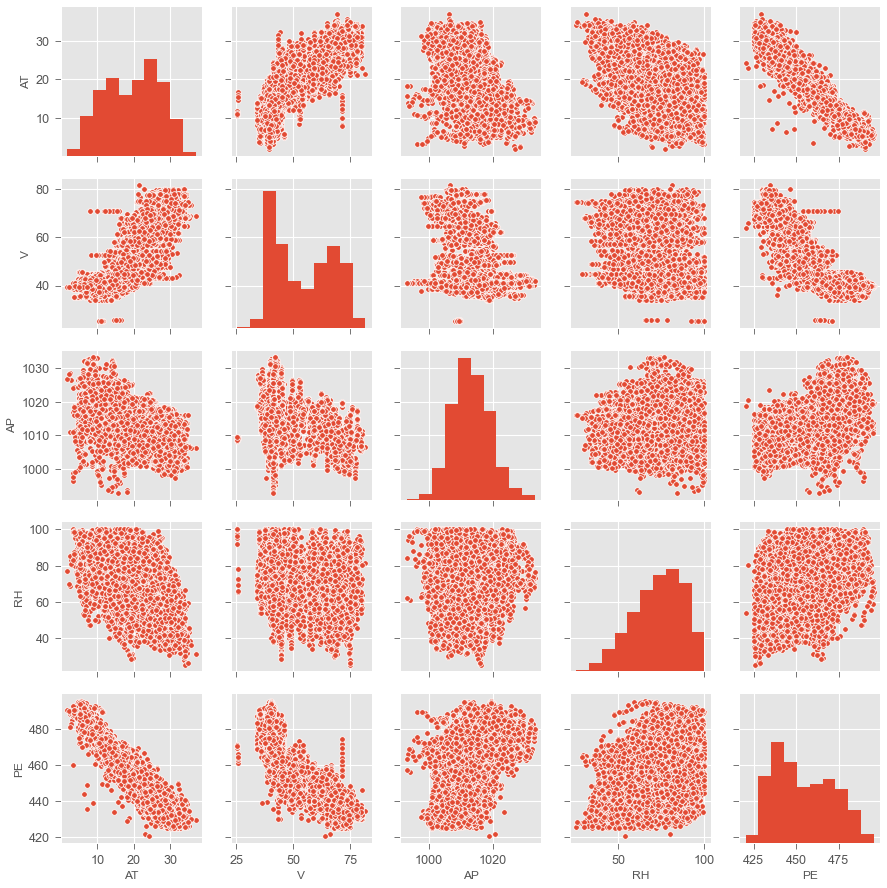

The variables seem to be correlated
 
 	 	 Data Statistics 

                AT            V           AP           RH           PE
count  9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean     19.651231    54.305804  1013.259078    73.308978   454.365009
std       7.452473    12.707893     5.938784    14.600269    17.066995
min       1.810000    25.360000   992.890000    25.560000   420.260000
25%      13.510000    41.740000  1009.100000    63.327500   439.750000
50%      20.345000    52.080000  1012.940000    74.975000   451.550000
75%      25.720000    66.540000  1017.260000    84.830000   468.430000
max      37.110000    81.560000  1033.300000   100.160000   495.760000
range    35.300000    56.200000    40.410000    74.600000    75.500000
IQR      12.210000    24.800000     8.160000    21.502500    28.680000


In [3]:
# 1.b.i
linreg.run_questions('1.b.i')

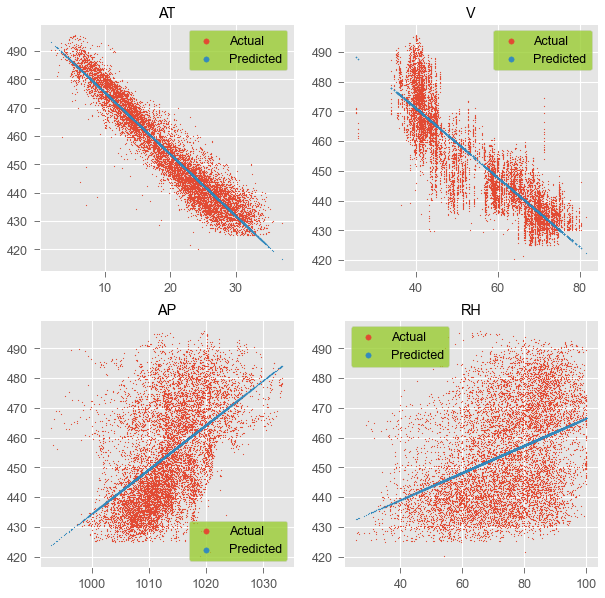

  variable  r_sq_adj  p_value
0       AT  0.898937      0.0
1        V  0.756492      0.0
2       AP  0.268692      0.0
3       RH  0.151851      0.0


 ~~~ 


The strongest association is for the variable AT, and least for RH 

                     There seem to be some outliers in variables V and RH 

                     Best fit seems to be for AT as confirmed by the high adjusted R-square value
                     


 ~~~ 




In [4]:
# 1.c
linreg.run_questions('1.c')

In [5]:
# 1.d
linreg.run_questions('1.d')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:47:10   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

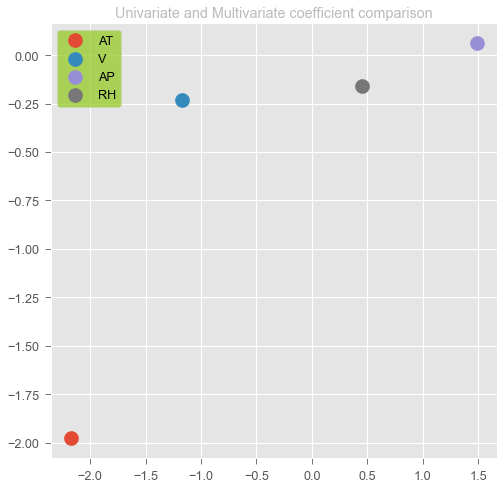



 ~~~ 


Only for variable AT the values for both regressions are similar
Other variables' coefficients change in both cases


 ~~~ 




In [6]:
# 1.e
linreg.run_questions('1.e')



 ~~~ 


AT
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.000     491.409     494.047
x1            -0.6103      0.124     -4.941      0.000      -0.852      -0.368
x2            -0.1251      0.007    -18.199      0.000      -0.139      -0.112
x3             0.0027      0.000     22.594      0.000       0.002       0.003


 ~~~ 




 ~~~ 


V
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.000     536.209     572.084
x1            -2.1444      0.509     -4.214      0.000      -3.142      -1.147
x2            -0.0027      0.009     -0.294      0.768      -0.021       0.015
x3             0.0001   5.45e-05      2.465      0.014    2.75e-05       0.000


 ~~~ 




 ~~~ 

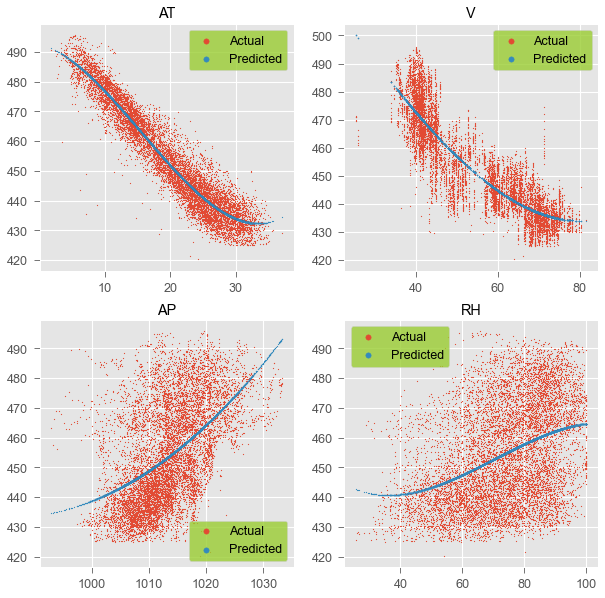

  variable  r_sq_adj  p_value
0       AT  0.911855      0.0
1        V  0.774951      0.0
2       AP  0.274712      0.0
3       RH  0.153477      0.0


 ~~~ 


p_values are ~0 for all variables in their non-linear univariate regression 

                     Hence, non-linear interaction is present 

                     Higher adjusted R-square values are also observed for ALL variables 

                     Hence, non-linear univariable regression is better than linear
                    


 ~~~ 




In [7]:
# 1.f
linreg.run_questions('1.f')



 ~~~ 


		 AT * V
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        530.5331      0.753    704.391      0.000     529.057     532.010
x1            -2.8781      0.036    -80.603      0.000      -2.948      -2.808
x2            -0.8632      0.017    -50.904      0.000      -0.896      -0.830
x3             0.0238      0.001     34.882      0.000       0.022       0.025


 ~~~ 




 ~~~ 


		 AT * AP
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        335.5473     25.160     13.336      0.000     286.228     384.867
x1            -1.2681      1.328     -0.955      0.340      -3.872       1.336
x2             0.1582      0.025      6.384      0.000       0.110       0.207
x3            -0.0008      0.001     -0.636      0.525      -0.003       0.002



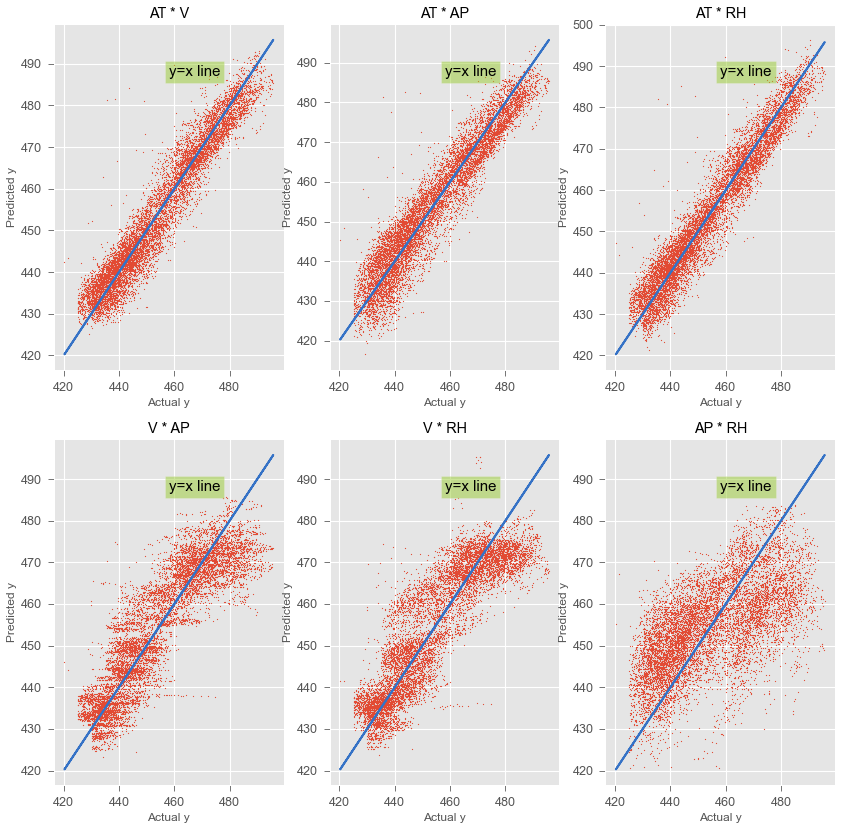



 ~~~ 


  interaction_term  r_sq_adj  total_p_value
0           AT * V  0.925217          0.000
1          AT * AP  0.900785          0.525
2          AT * RH  0.924554          0.000
3           V * AP  0.788522          0.000
4           V * RH  0.776040          0.000
5          AP * RH  0.384706          0.002


 ~~~ 


x3 is the interaction variable in regression. 
                 For (AP,RH) the p-value is 0.002 and (AT,AP) the p-value is 0.525. Rest have p-value 0.
                 Hence, except for (AT,AP) there is statistical evidence (for alpha=0.05) for interaction.
                 However, R-square for (AP,RH) is 0.38 which means it is not a good fit model.
              


 ~~~ 




In [8]:
# 1.g
linreg.run_questions('1.g')

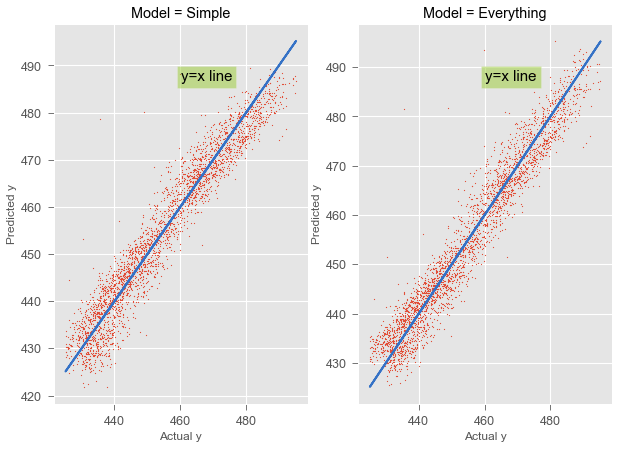



 ~~~ 


        Model  r_sq_adj  overall_p_value  mse_train   mse_test
0      Simple  0.929365              0.0  20.600777  21.161351
1  Everything  0.938599              0.0  17.880909  18.679861


 ~~~ 


Lower train and test errors for the complicated model. Hence, better


 ~~~ 




In [9]:
# 1.h
linreg.run_questions('1.h')

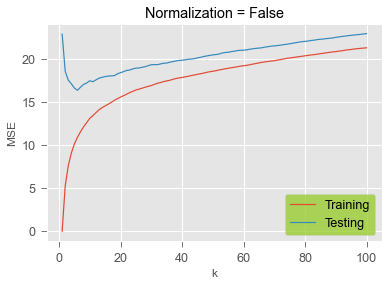

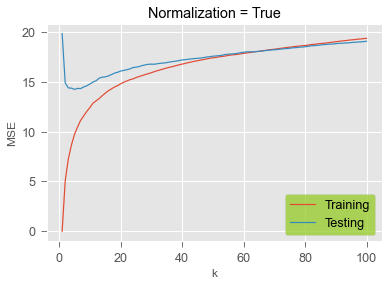



 ~~~ 


  data_transform  best_k  lowerst_test_mse
0            Raw       6         16.395772
1     Normalized       5         14.233755


 ~~~ 




In [10]:
# 1.i
linreg.run_questions('1.i')

In [11]:
# 1.j
linreg.run_questions('1.j')



 ~~~ 


                       lowest_test_mse
Simple Regression            21.161351
Everything Regression        18.679861
Raw KNN                      16.395772
Normalized KNN               14.233755


 ~~~ 


As evident Normalized KNN gives the lowest MSE while Simple Regression gives the highest.
                This is intuitive since simple regression is not normalized, and does not consider interaction.
                Normalized KNN by virtue of its structure gives the best possible model.
              


In [12]:
# 2
linreg.run_questions('2')

 
        
            (a) Better - flexible model will capture different relationships between variables 
            when sample size is large.

            (b) Worse - flexible model might overfit when sample size is small.

            (c) Better - flexible model will be able to capture high degrees of freedom and complicated
            relationships between input variables.

            (d) Worse - flexible model will try to fit the data even though the noise / variance is high   
        


In [13]:
# 3
linreg.run_questions('3')

   x1  x2  x3      y  dist_from_origin
0   0   3   0    Red          3.000000
1   2   0   0    Red          2.000000
2   0   1   3    Red          3.162278
3   0   1   2  Green          2.236068
4  -1   0   1  Green          1.414214
5   1   1   1    Red          1.732051


 ~~~ 


(b) and (c) 


 1 closest points
   x1  x2  x3      y  dist_from_origin
4  -1   0   1  Green          1.414214

 3 closest points
   x1  x2  x3      y  dist_from_origin
4  -1   0   1  Green          1.414214
5   1   1   1    Red          1.732051
1   2   0   0    Red          2.000000


 ~~~ 


KNN Predictions : {1: 'Green', 3: 'Red'} 

(d) 	 Small. A smaller K would be flexible for a non-linear decision boundary


 ~~~ 


